# NYC Airbnb 探索性數據分析 (EDA) 
---
### 摘要
本分析旨在透過 2019 年 NYC Airbnb 數據，識別市場趨勢、價格分佈及關鍵競爭維度。

In [528]:
import pandas as pd
import geopandas as gpd
import geodatasets
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as PathEffects
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import matplotlib.patheffects as pe
import plotly.express as px
import gradio as gr
import seaborn as sns
import kagglehub
from kagglehub import KaggleDatasetAdapter

sns.set_theme(style="white")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']


## 2. 數據載入與初步結構檢視
本階段確保數據完整性，並定義核心分析維度。

In [529]:
df = pd.read_csv("nyc_airbnb_data.csv")

print(f"數據集維度: {df.shape[0]:,} 行 x {df.shape[1]} 欄")

數據集維度: 31,566 行 x 18 欄


## 3. 行政區定價與佔比分析 (Geographic Analysis)
透過熱力圖與統計圖表，觀察 Manhattan、Brooklyn 等行政區的定價規律與市場佔有率。

In [530]:
CORAL_COLOR = (236/255, 92/255, 87/255)

In [531]:
NTA_JSON_PATH = './geometry/nyc_nta.json'
BORO_JSON_PATH = './geometry/nyc_bb.json'

gdf_listings = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326" # 設定座標系為 WGS84 (經緯度)
)

gdf_nta = gpd.read_file(NTA_JSON_PATH).to_crs(epsg=4326)
gdf_boro = gpd.read_file(BORO_JSON_PATH).to_crs(epsg=4326)

# 空間連接
joined = gpd.sjoin(gdf_listings, gdf_nta, how="inner", predicate="within")
counts = joined.index_right.value_counts()

# 初始化並填入數量
gdf_nta['listing_count'] = 0
gdf_nta.loc[counts.index, 'listing_count'] = counts.values

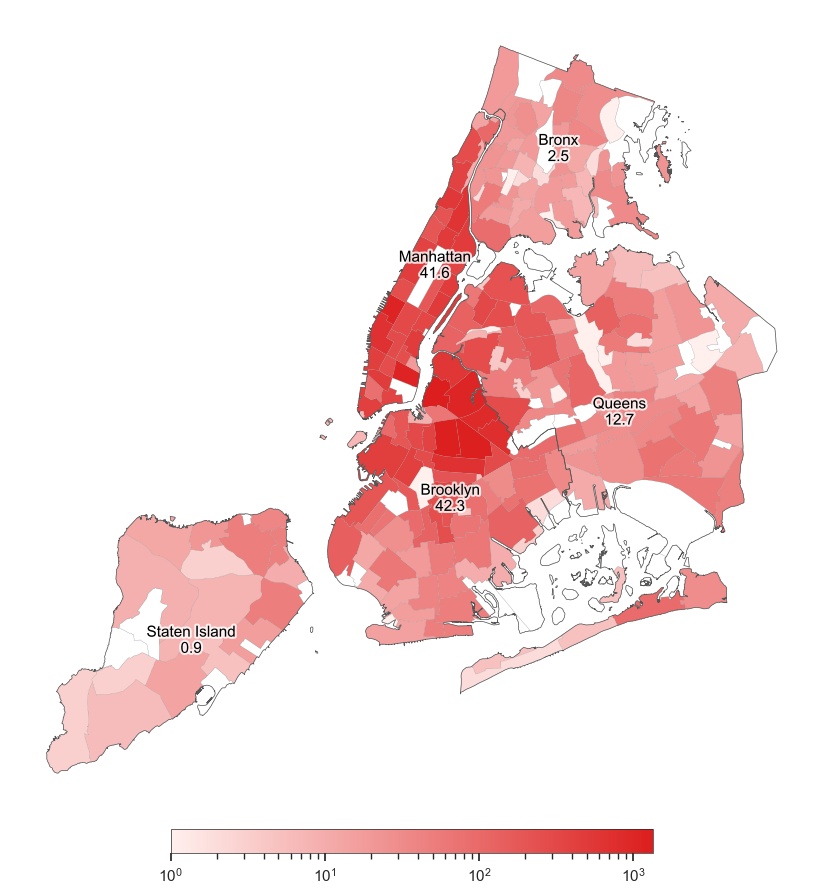

In [532]:
# 計算各行政區佔比
boro_percentages = df['neighbourhood_group'].value_counts(normalize=True) * 100

fig, ax = plt.subplots(figsize=(10, 10))

vmin = max(gdf_nta['listing_count'].min(), 1) 
vmax = gdf_nta['listing_count'].max()
norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)

dark_coral = (220/255, 30/255, 30/255)
pale_coral = (255/255, 240/255, 238/255)
colors_list = [pale_coral, dark_coral]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("gray_to_coral", colors_list)

gdf_nta.plot(
    column='listing_count',
    cmap=custom_cmap,
    norm=norm,
    linewidth=0.1,
    edgecolor='grey',
    legend=False,
    ax=ax
)

gdf_boro.plot(
    ax=ax,
    facecolor='none',
    edgecolor='#555555',
    linewidth=0.5,
    zorder=2
)

# 行政區名稱與百分比
gdf_boro_labels = gdf_boro.copy()
gdf_boro_labels['coords'] = gdf_boro_labels['geometry'].apply(
    lambda x: x.representative_point().coords[:]
)
gdf_boro_labels['coords'] = [c[0] for c in gdf_boro_labels['coords']]

for idx, row in gdf_boro_labels.iterrows():
    boro_name = row.get('BoroName', 'Unknown')
    
    # 獲取該區的百分比並格式化 ---
    # 使用 .get() 避免如果名字不完全匹配時報錯 (預設為 0)
    pct = boro_percentages.get(boro_name, 0)
    
    # 建立標籤文字：名稱換行接百分比
    label_text = f"{boro_name}\n{pct:.1f}"
    
    plt.annotate(
        text=label_text, 
        xy=row['coords'],
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=11,          # 字體大小
        fontweight='bold',
        color='black',
        path_effects=[
            pe.withStroke(linewidth=3, foreground="white", alpha=0.8)
        ],
        zorder=3
    )

cbar_mappable = ScalarMappable(norm=norm, cmap=custom_cmap)
cbar = fig.colorbar(
    cbar_mappable, 
    ax=ax, 
    orientation='horizontal', 
    shrink=0.5, 
    pad=0.02
)
cbar.outline.set_linewidth(0.5)

ax.set_axis_off()
plt.tight_layout()
plt.show()

## 針對房源數前30名的區域進行分析

In [533]:
NUM = 30
RED = (236/255, 89/255, 90/255)
YELLOW = (247/255, 195/255, 78/255)
GRAY = (150/255, 149/255, 146/255)

In [534]:
sns.set_theme(style="white")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False


In [ ]:
top30_idx = df['neighbourhood'].value_counts().nlargest(NUM).index

plot_data = (
    df[df['neighbourhood'].isin(top30_idx)]
    .groupby(['neighbourhood_group', 'neighbourhood'])
    .size()
    .reset_index(name='count')
    .sort_values(['neighbourhood_group', 'count'], ascending=[True, False])
)

In [536]:
sorted_neighbourhoods = plot_data['neighbourhood'].tolist()
sorted_boroughs = plot_data['neighbourhood_group'].tolist()

### 房源數量橫向長條圖

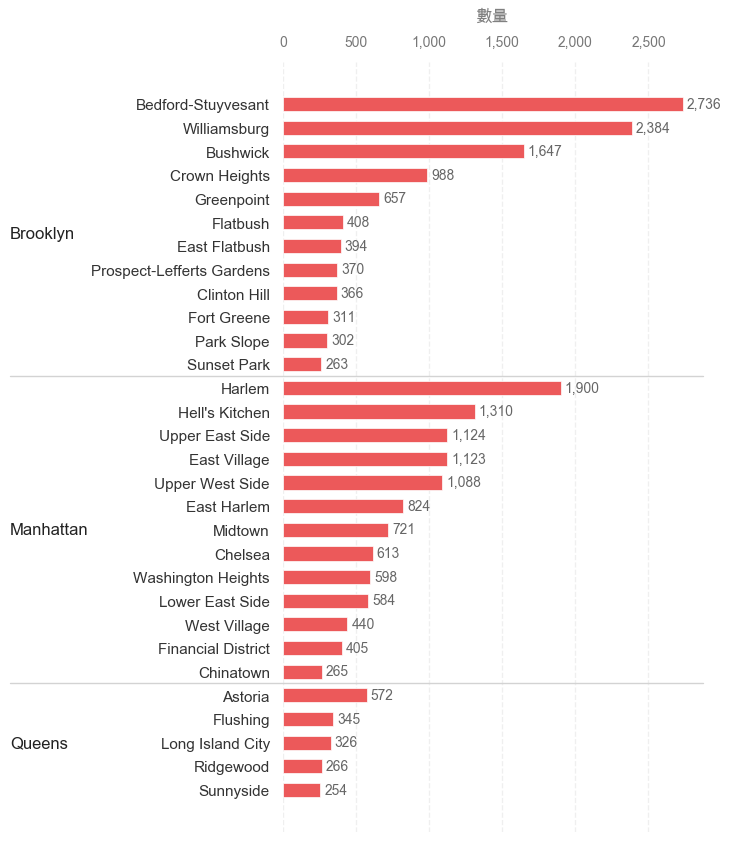

In [537]:
counts = plot_data['count'].tolist()

# 繪圖
fig, ax = plt.subplots(figsize=(7, 10))

# 設定 Y 軸位置
y_pos = range(len(plot_data))

# 繪製長條圖
bars = ax.barh(
    y_pos, 
    counts, 
    height=0.6,
    color=RED,
    edgecolor='white',
    linewidth=0.5
)

# 加入數值標籤
max_val = max(counts)
for i, v in enumerate(counts):
    ax.text(
        v + max_val * 0.01, i, 
        f'{v:,}', 
        va='center', 
        color='#666666', 
        fontsize=10,
        fontweight='normal'
    )

# 視覺分組與延伸分隔線
ax.set_yticks(y_pos)
ax.set_yticklabels(sorted_neighbourhoods, fontsize=11, color='#333333')
ax.invert_yaxis() 

# X 軸設定
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_xlabel('數量', color='gray', labelpad=10)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.tick_params(axis='x', length=0, labelsize=10, colors='#777777', pad=9)

# 垂直格線
ax.grid(axis='x', linestyle='--', alpha=0.3)

# 處理分組
unique_boroughs = []
borough_indices = {} 

for idx, b in enumerate(sorted_boroughs):
    if b not in unique_boroughs:
        unique_boroughs.append(b)
    if b not in borough_indices:
        borough_indices[b] = []
    borough_indices[b].append(idx)

for i, b in enumerate(unique_boroughs):
    indices = borough_indices[b]
    start_idx = indices[0]
    end_idx = indices[-1]
    
    # 標示行政區 (置中)
    center_y = (start_idx + end_idx) / 2
    
    # 我們將文字放在 -0.35 的位置 (軸寬度的 35% 向左延伸)
    ax.text(-0.65, center_y, b, 
            transform=ax.get_yaxis_transform(),
            ha='left', va='center', 
            fontsize=12, fontweight='bold', color='#222222')
    
    # 畫延伸分隔線
    # 邏輯：除了最後一個群組外，都要畫線
    if i < len(unique_boroughs) - 1:
        line_y = end_idx + 0.5
        
        # xmin=-0.4: 讓線條延伸到 X 軸左側 40% 的位置，覆蓋住文字標籤區 (-0.35)
        # clip_on=False: 允許線條畫在座標軸框框外面
        ax.axhline(
            y=line_y, 
            color='lightgray', 
            linewidth=1, 
            xmin=-0.65,   # 延伸起點 (負數代表往左延伸出軸外)
            xmax=1,      # 終點 (1 代表軸的最右邊)
            clip_on=False 
        )

sns.despine(top=True, right=True, left=True, bottom=True)

# 左邊界要留夠大，才能容納延伸出去的線和文字 (0.3 左右)
plt.subplots_adjust(left=0.3) 

plt.show()

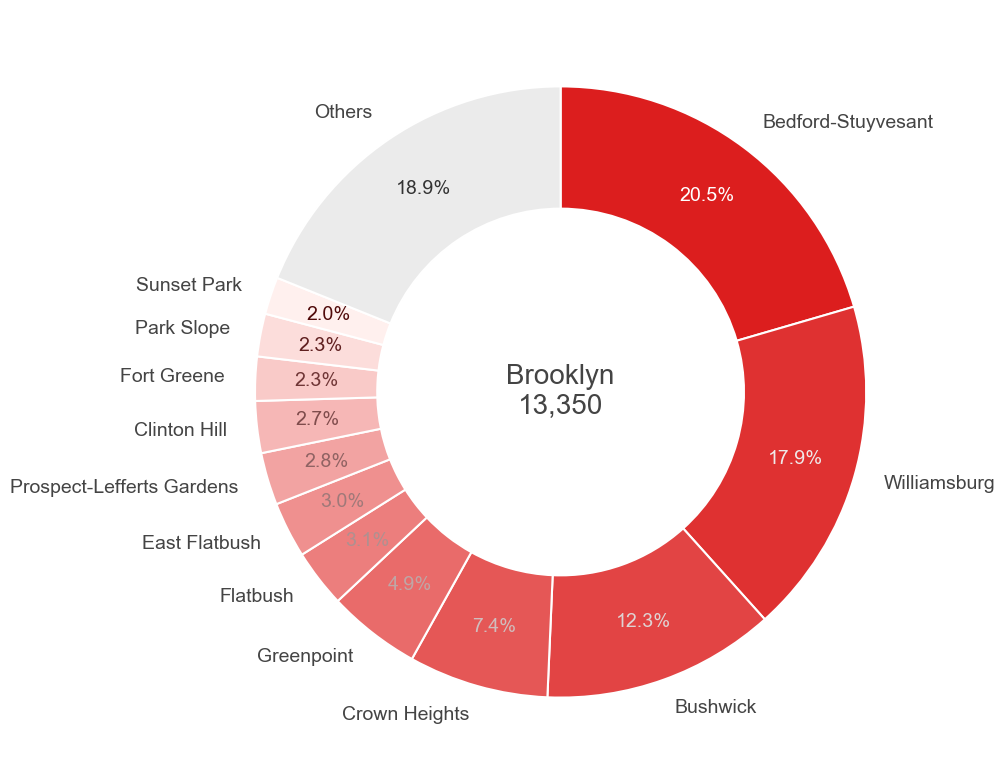

In [538]:

df_man = df[df['neighbourhood_group'] == 'Brooklyn'].copy()
counts = df_man['neighbourhood'].value_counts()

TOP_N = 12
top_counts = counts.head(TOP_N)
others_count = pd.Series({'Others': counts.iloc[TOP_N:].sum()})
plot_data = pd.concat([top_counts, others_count])

# --- A. 定義顏色端點 ---
# 切片背景色：深紅 -> 淺粉
slice_start = (220/255, 30/255, 30/255)   # Dark Coral
slice_end   = (255/255, 240/255, 238/255) # Pale Coral

# 文字顏色：純白 -> 深紅 (或深灰)
# 讓淺色背景上的文字變深，深色背景上的文字變白
text_start = (1, 1, 1)                    # White (對應深紅背景)
text_end   = (80/255, 10/255, 10/255)     # Very Dark Red (對應淺粉背景)

# --- B. 建立兩個 Colormap ---
cmap_slice = LinearSegmentedColormap.from_list("slice_grad", [slice_start, slice_end])
cmap_text  = LinearSegmentedColormap.from_list("text_grad", [text_start, text_end])

# --- C. 生成對應的顏色列表 ---
# 產生 0 到 1 的序列
steps = np.linspace(0, 1, TOP_N)

# 生成切片顏色列表
slice_colors = [cmap_slice(i) for i in steps]
# 生成對應的文字顏色列表 (邏輯一致：第1個切片用第1個文字色)
text_colors = [cmap_text(i) for i in steps]

final_slice_colors = slice_colors + [(0.92, 0.92, 0.92)] # Others 背景: 淺灰
final_text_colors  = text_colors  + [(0.2, 0.2, 0.2)]    # Others 文字: 深灰

fig, ax = plt.subplots(figsize=(10, 8))

wedges, texts, autotexts = ax.pie(
    plot_data, 
    labels=plot_data.index,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    colors=final_slice_colors, # 套用背景色
    pctdistance=0.8,
    textprops={'fontsize': 14, 'color': '#444444'}, # 外部標籤預設顏色
    wedgeprops={'width': 0.4, 'edgecolor': 'white', 'linewidth': 1.5}
)


# 遍歷每一個數值標籤 (autotexts)，套用我們生成的文字漸層色
for i, autotext in enumerate(autotexts):
    # 設定顏色
    autotext.set_color(final_text_colors[i])
    # 設定字體樣式 (加粗看起來更有質感)
    autotext.set_fontweight('bold')
    autotext.set_fontsize(14)
        

total_listings = df_man.shape[0]
ax.text(0, 0, f'Brooklyn\n{total_listings:,}', 
        ha='center', va='center', fontsize=20, fontweight='bold', color='#444444')

plt.tight_layout()
plt.show()

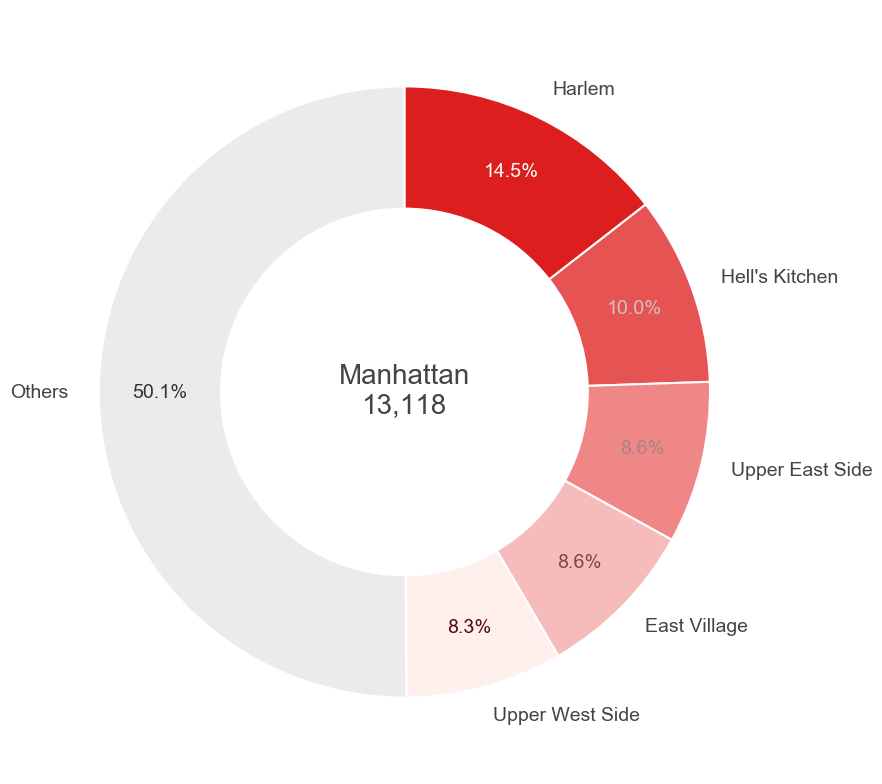

In [539]:

df_man = df[df['neighbourhood_group'] == 'Manhattan'].copy()
counts = df_man['neighbourhood'].value_counts()

TOP_N = 5
top_counts = counts.head(TOP_N)
others_count = pd.Series({'Others': counts.iloc[TOP_N:].sum()})
plot_data = pd.concat([top_counts, others_count])

# --- A. 定義顏色端點 ---
# 切片背景色：深紅 -> 淺粉
slice_start = (220/255, 30/255, 30/255)   # Dark Coral
slice_end   = (255/255, 240/255, 238/255) # Pale Coral

# 文字顏色：純白 -> 深紅 (或深灰)
# 讓淺色背景上的文字變深，深色背景上的文字變白
text_start = (1, 1, 1)                    # White (對應深紅背景)
text_end   = (80/255, 10/255, 10/255)     # Very Dark Red (對應淺粉背景)

# --- B. 建立兩個 Colormap ---
cmap_slice = LinearSegmentedColormap.from_list("slice_grad", [slice_start, slice_end])
cmap_text  = LinearSegmentedColormap.from_list("text_grad", [text_start, text_end])

# --- C. 生成對應的顏色列表 ---
# 產生 0 到 1 的序列
steps = np.linspace(0, 1, TOP_N)

# 生成切片顏色列表
slice_colors = [cmap_slice(i) for i in steps]
# 生成對應的文字顏色列表 (邏輯一致：第1個切片用第1個文字色)
text_colors = [cmap_text(i) for i in steps]

final_slice_colors = slice_colors + [(0.92, 0.92, 0.92)] # Others 背景: 淺灰
final_text_colors  = text_colors  + [(0.2, 0.2, 0.2)]    # Others 文字: 深灰

fig, ax = plt.subplots(figsize=(10, 8))

wedges, texts, autotexts = ax.pie(
    plot_data, 
    labels=plot_data.index,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    colors=final_slice_colors, # 套用背景色
    pctdistance=0.8,
    textprops={'fontsize': 14, 'color': '#444444'}, # 外部標籤預設顏色
    wedgeprops={'width': 0.4, 'edgecolor': 'white', 'linewidth': 1.5}
)


# 遍歷每一個數值標籤 (autotexts)，套用我們生成的文字漸層色
for i, autotext in enumerate(autotexts):
    # 設定顏色
    autotext.set_color(final_text_colors[i])
    # 設定字體樣式 (加粗看起來更有質感)
    autotext.set_fontweight('bold')
    autotext.set_fontsize(14)
        

total_listings = df_man.shape[0]
ax.text(0, 0, f'Manhattan\n{total_listings:,}', 
        ha='center', va='center', fontsize=20, fontweight='bold', color='#444444')

# plt.title('Manhattan 房源佔比 (文字顏色隨背景動態調整)', fontsize=15, pad=20, fontweight='bold', color='#333333')
plt.tight_layout()
plt.show()

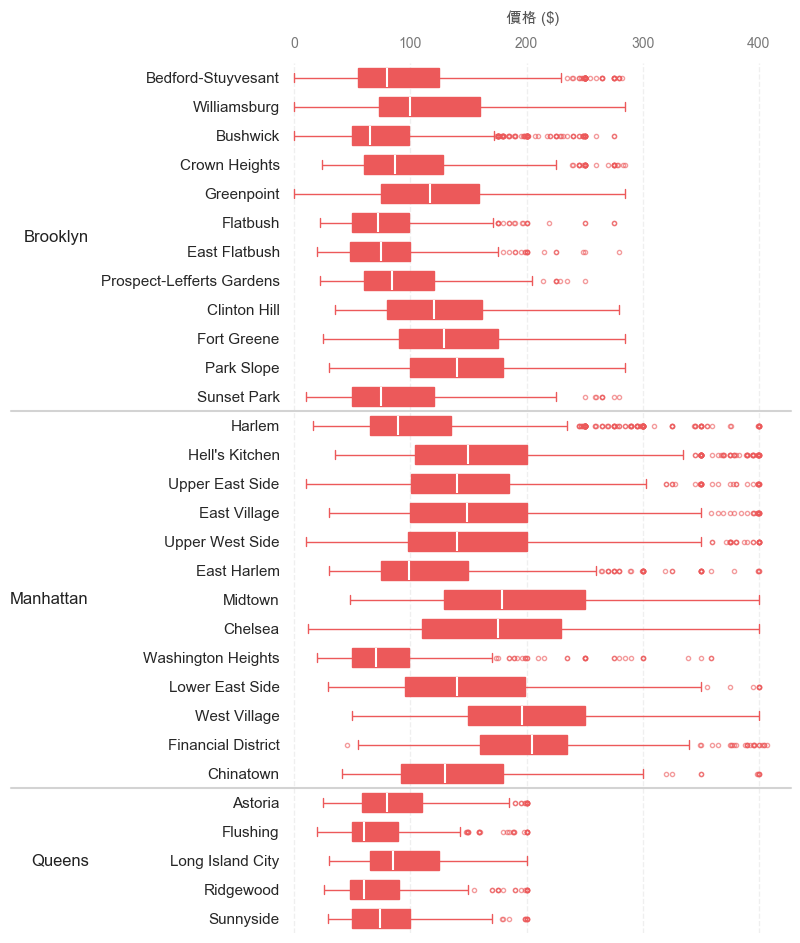

In [ ]:
lw = 1 # 線條稍粗一點點看起來更有質感

box_props = dict(edgecolor=RED, linewidth=lw, facecolor=RED) # 面跟邊都紅
line_props = dict(color=RED, linewidth=lw)
median_props = dict(color='white', linewidth=1.5)
flier_props = dict(marker='o', markerfacecolor='none', markeredgecolor=RED, markersize=3, alpha=0.6)

fig, ax = plt.subplots(figsize=(8, 10)) # 寬度調整配合左側標籤

df_plot = df[df['neighbourhood'].isin(top30_idx)].copy()

# 繪製箱型圖
sns.boxplot(
    data=df_plot,
    x='price',
    y='neighbourhood',
    order=sorted_neighbourhoods,
    color=RED,
    width=0.65,
    # showfliers=False, # 建議隱藏離群值，不然箱子會變很扁
    
    # 傳入自訂屬性
    boxprops=box_props,
    whiskerprops=line_props,
    capprops=line_props,
    medianprops=median_props,
    flierprops=flier_props,
    
    ax=ax,
    zorder=3
)


# 整理行政區索引
unique_boroughs = []
borough_indices = {} 
for idx, b in enumerate(sorted_boroughs):
    if b not in unique_boroughs:
        unique_boroughs.append(b)
    if b not in borough_indices:
        borough_indices[b] = []
    borough_indices[b].append(idx)

# 迴圈繪製標籤與線條
for i, b in enumerate(unique_boroughs):
    indices = borough_indices[b]
    start_idx = indices[0]
    end_idx = indices[-1]
    
    # 計算中心點
    center_y = (start_idx + end_idx) / 2
    
    # 1. 行政區標籤 (置中、靠左)
    # x = -0.35 (配合之前的設計，放在軸外左側)
    ax.text(-0.35, center_y, b, 
            transform=ax.get_yaxis_transform(),
            ha='right', va='center', 
            fontsize=12, fontweight='bold', color='#222222')
    
    # 2. 畫延伸分隔線 (除了最後一組)
    if i < len(unique_boroughs) - 1:
        line_y = end_idx + 0.5
        ax.axhline(
            y=line_y, 
            color='lightgray', 
            linewidth=1.5, 
            xmin=-0.5,    # 從文字下方延伸出來
            xmax=1, 
            clip_on=False
        )

# X 軸設定
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_xlabel(' 價格 ($)', fontsize=11, color='#555555', labelpad=10)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax.tick_params(axis='x', length=0, labelsize=10, colors='#777777', pad=9)

# Y 軸設定
ax.set_ylabel('')
ax.tick_params(axis='y', length=-10) # 隱藏刻度線

# 垂直格線
ax.grid(axis='x', linestyle='--', alpha=0.3)

# 去除邊框
sns.despine(left=True, bottom=True, top=True, right=True)

# 調整邊距 (左邊留白給文字)
plt.subplots_adjust(left=0.3, right=0.95, top=0.92, bottom=0.05)

plt.show()

/var/folders/22/2501c0491vb7rb4pnbwmspfh0000gp/T/ipykernel_74073/224562125.py:2: Pandas4Warning: Starting with pandas version 4.0 all arguments of sum will be keyword-only.
  structure_pct = structure_data.div(structure_data.sum(1), axis=0) * 100


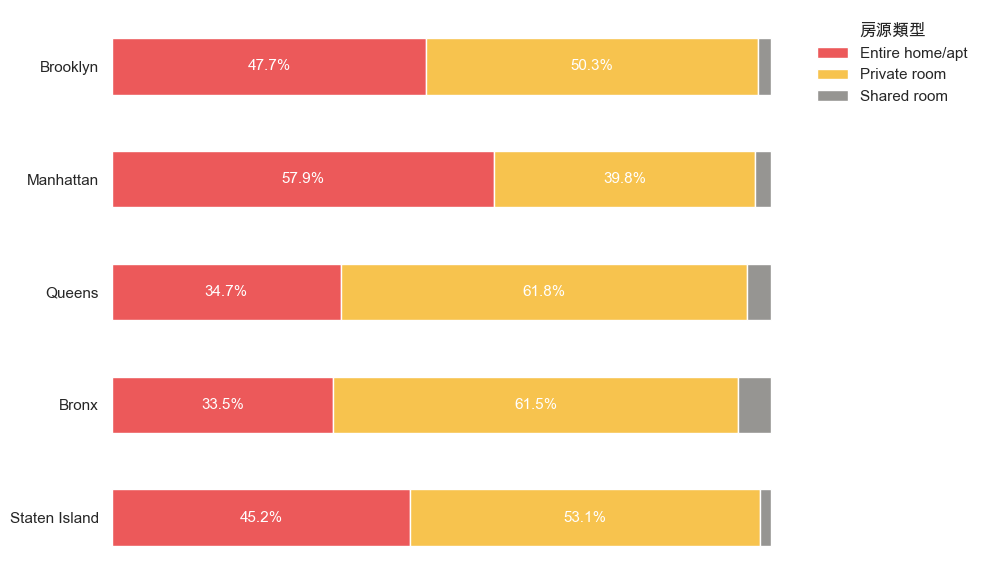

In [541]:

structure_data = pd.crosstab(df['neighbourhood_group'], df['room_type'])
structure_pct = structure_data.div(structure_data.sum(1), axis=0) * 100

# 重新排序行政區
target_order = ["Staten Island", "Bronx", "Queens", "Manhattan", "Brooklyn", ]
structure_pct = structure_pct.reindex(target_order)

# --------------------------
# 2. 定義顏色與參數
# --------------------------
# 將 RGB (0-255) 轉換為 Matplotlib 的 (0-1) 格式
custom_colors = [
    RED,
    YELLOW,
    GRAY
]

# --------------------------
# 3. 繪圖
# --------------------------
ax = structure_pct.plot(
    kind='barh', 
    stacked=True, 
    figsize=(10, 6), 
    color=custom_colors,
    width=0.5,          # 【修改】將寬度縮小 (原本 0.7)
    edgecolor='white',  # 白色邊框
    linewidth=1,
    rot=0               # 確保文字不旋轉
)

# --------------------------
# 4. 修飾與標籤
# --------------------------
plt.xlabel('')
plt.ylabel('')
ax.set_xticks([]) # 隱藏 X 軸刻度

sns.despine(left=True, bottom=True) # 移除四周邊框

# 長條圖中百分比標籤
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    
    # 只在寬度夠大的時候顯示標籤，避免擠在一起
    if width > 5: 
        # 為了增加對比度，可以在這裡判斷顏色
        # 簡單起見，我們維持白色文字，並加上文字陰影效果(path_effects)會更清晰，
        # 但這裡先保持純文字，若黃色背景字看不清，可將 color 改為 'black'
        ax.text(
            x + width/2, 
            y + height/2, 
            f'{width:.1f}%', 
            ha='center', va='center', 
            color='white', # 若黃色背景上的白字看不清楚，可考慮改為 '#333333'
            fontsize=11, 
            fontweight='bold'
        )

# 圖例設定
plt.legend(
    bbox_to_anchor=(1.0, 1), # 放在右上角外側
    loc='upper left', 
    frameon=False,           # 移除圖例邊框，更簡潔
    title='房源類型'          # 加上圖例標題
)

plt.tight_layout()
plt.show()

In [542]:
import pandas as pd

# 1. 篩選出曼哈頓 (Manhattan) 下的金融區 (Financial District) 資料
# 使用多重條件篩選，確保行政區與社區名稱精準匹配
financial_district_df = df[
    (df['neighbourhood_group'] == 'Manhattan') & 
    (df['neighbourhood'] == 'Financial District')
]

# 2. 針對「房源類型 (room_type)」進行分組，並計算「價格 (price)」的中位數
median_prices = financial_district_df.groupby('room_type')['price'].median()

# 3. 顯示結果 (依價格由高至低排序，方便閱讀)
print(median_prices.sort_values(ascending=False))

room_type
Entire home/apt    223.0
Shared room        150.0
Private room       120.0
Name: price, dtype: float64


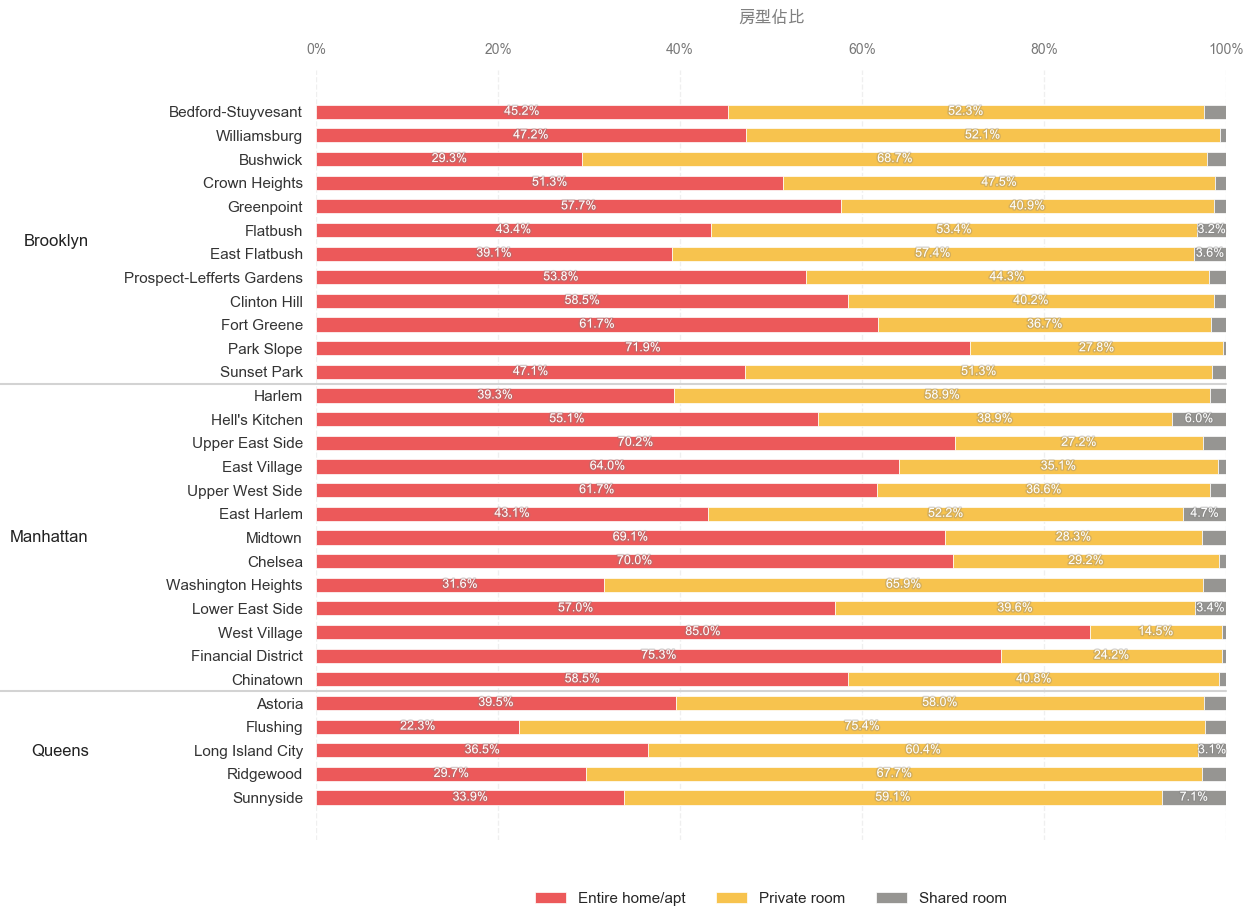

In [ ]:
color_map = {
    'Entire home/apt': RED,   # 紅
    'Private room':    YELLOW,  # 黃
    'Shared room':     GRAY  # 灰
}

target_cols = ['Entire home/apt', 'Private room', 'Shared room']

df_filtered = df[df['neighbourhood'].isin(top30_idx)]

pivot_data = (
    df_filtered.groupby(['neighbourhood_group', 'neighbourhood', 'room_type'])
    .size()
    .unstack(fill_value=0)
)

pivot_data['total'] = pivot_data.sum(axis=1)
pivot_data = pivot_data.sort_values(['neighbourhood_group', 'total'], ascending=[True, False])

pct_data = pivot_data[target_cols].div(pivot_data['total'], axis=0) * 100

# 準備繪圖用的索引列表 (用於控制 Y 軸位置)
# reset_index 後，資料會變平展，方便我們用 index (0, 1, 2...) 來畫圖
plot_data = pct_data.reset_index()
neighbourhoods = plot_data['neighbourhood'].tolist()
boroughs = plot_data['neighbourhood_group'].tolist()


fig, ax = plt.subplots(figsize=(14, 10))

# 繪製堆疊長條圖
# 我們不直接用 pandas plot，而是用 matplotlib 的 barh 堆疊，這樣對位置控制更精準
y_pos = range(len(plot_data))
left_offset = pd.Series([0.0] * len(plot_data))

for col in target_cols:
    values = plot_data[col]
    ax.barh(
        y_pos, 
        values, 
        left=left_offset, 
        height=0.6,          # 設定長條寬度 (參考圖較細)
        label=col, 
        color=color_map[col],
        edgecolor='white',
        linewidth=0.5
    )
    
    # 加入數據標籤 (百分比)
    for i, (val, left) in enumerate(zip(values, left_offset)):
        if val > 3: # 數值太小不顯示
            ax.text(
                left + val/2, i, 
                f'{val:.1f}%', 
                ha='center', va='center', 
                color='white', 
                fontsize=9, 
                fontweight='bold',
                path_effects=[pe.withStroke(linewidth=2, foreground='gray', alpha=0.3)]
            )
    
    left_offset += values

ax.set_yticks(y_pos)
ax.set_yticklabels(neighbourhoods, fontsize=11, color='#333333')
ax.invert_yaxis() # 讓第一筆資料在最上面


ax.set_xlim(0, 100)
ax.set_xlabel('房型佔比', color='gray', labelpad=15)


# 行政區分組線與標籤
unique_boroughs = []
borough_indices = {} # 記錄每個行政區包含哪些 index (列號)

for idx, b in enumerate(boroughs):
    if b not in unique_boroughs:
        unique_boroughs.append(b)
    if b not in borough_indices:
        borough_indices[b] = []
    borough_indices[b].append(idx)

# 畫線與標籤
for i, b in enumerate(unique_boroughs):
    indices = borough_indices[b]
    start_idx = indices[0]
    end_idx = indices[-1]
    
    # 計算標籤的中心位置 (垂直置中)
    center_y = (start_idx + end_idx) / 2
    
    # 在左側標示行政區
    ax.text(-25, center_y, b, 
            ha='right', va='center', 
            fontsize=12, fontweight='bold', color='#222222')
    
    # 分隔線 (畫在每一個群組的下方，除了最後一個群組)
    # y 位置設為 end_idx + 0.5 (即兩條 bar 中間)
    if i < len(unique_boroughs) - 1:
        line_y = end_idx + 0.5
        ax.axhline(y=line_y, color='lightgray', linewidth=1.5, xmin=-0.35, clip_on=False)

# 增加垂直格線 (參考圖有垂直線)
ax.grid(axis='x', linestyle='--', alpha=0.3)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}%'))
ax.tick_params(axis='x', length=0, labelsize=10, colors='#777777', pad=9) # pad 增加文字與線的距離


sns.despine(top=True, right=True, left=True, bottom=True)

# 調整圖例位置 (置於下方)
plt.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.05),
    ncol=3, 
    frameon=False, 
    fontsize=11
)


# 調整 layout 確保左邊的行政區文字不會被切掉
plt.subplots_adjust(left=0.25) 

plt.show()

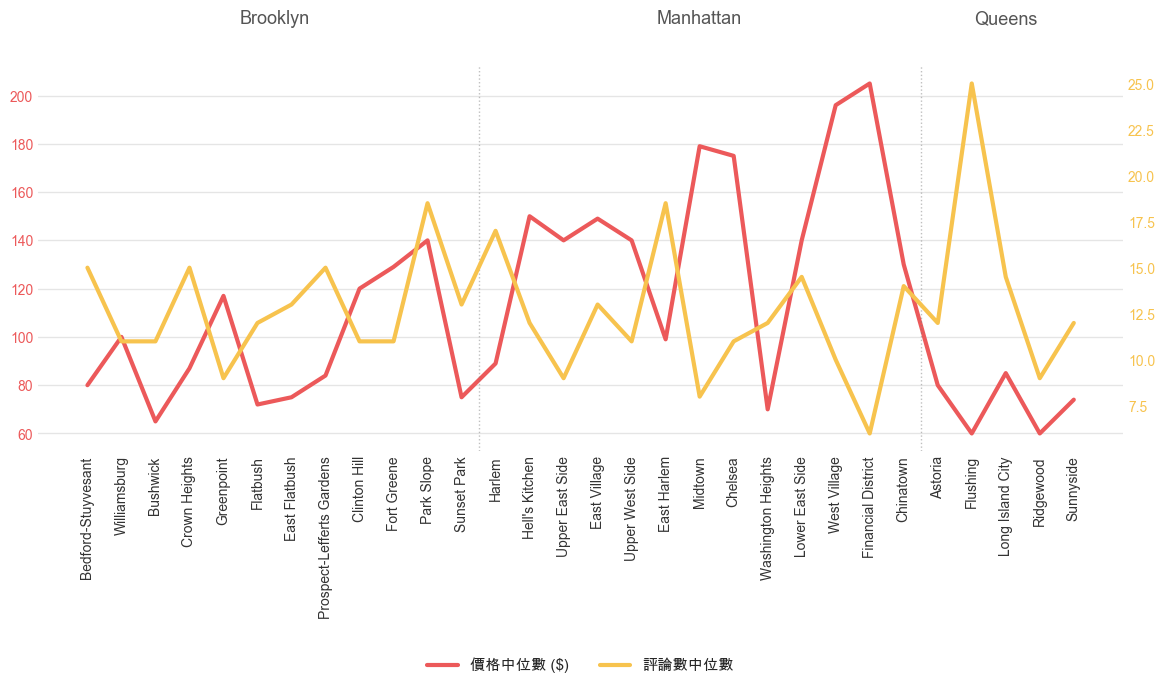

In [ ]:
COLOR_PRICE = RED     # Coral Red
COLOR_REVIEW = YELLOW # Yellow


df_filtered = df[df['neighbourhood'].isin(top30_idx)].copy()

# 計算兩種指標的中位數
agg_data = (
    df_filtered.groupby(['neighbourhood_group', 'neighbourhood'])
    [['price', 'number_of_reviews']]
    .median()
    .reset_index()
)

# 排序邏輯
count_helper = (
    df_filtered.groupby(['neighbourhood_group', 'neighbourhood'])
    .size()
    .reset_index(name='count')
)
plot_data = pd.merge(agg_data, count_helper, on=['neighbourhood_group', 'neighbourhood'])
plot_data = plot_data.sort_values(['neighbourhood_group', 'count'], ascending=[True, False])

neighbourhoods = plot_data['neighbourhood'].tolist()
boroughs = plot_data['neighbourhood_group'].tolist()
prices = plot_data['price'].tolist()
reviews = plot_data['number_of_reviews'].tolist()


fig, ax1 = plt.subplots(figsize=(14, 7))

x_pos = range(len(neighbourhoods))

# --- 左軸：價格 (Price) ---
ax1.plot(
    x_pos, prices, 
    color=COLOR_PRICE, 
    linewidth=3, 
    label='價格中位數 ($)'
)
# ax1.set_ylabel('價格中位數 ($)', fontsize=12, color=COLOR_PRICE, fontweight='bold')

# 左軸設定：加入 length=0 移除刻度線
ax1.tick_params(axis='y', length=0, labelcolor=COLOR_PRICE, labelsize=10)
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# --- 右軸：評論數 (Reviews) ---
ax2 = ax1.twinx()
ax2.plot(
    x_pos, reviews, 
    color=COLOR_REVIEW, 
    linewidth=3, 
    label='評論數中位數'
)
# ax2.set_ylabel('評論數中位數', fontsize=12, color=COLOR_REVIEW, fontweight='bold')
ax2.tick_params(axis='y', length=0, labelcolor=COLOR_REVIEW, labelsize=10)

# --- X 軸與網格 ---
ax1.set_xticks(x_pos)
ax1.set_xticklabels(neighbourhoods, rotation=90, ha='center', fontsize=10, color='#333333')
ax1.set_xlabel('')

# 為了讓畫面更乾淨，這裡也可以將 X 軸的刻度線拿掉
ax1.tick_params(axis='x', length=0)

ax1.grid(axis='y', linestyle='-', alpha=0.2, color='gray')

# --- 行政區分組與分隔線 ---
unique_boroughs = []
borough_indices = {} 
for idx, b in enumerate(boroughs):
    if b not in unique_boroughs:
        unique_boroughs.append(b)
    if b not in borough_indices:
        borough_indices[b] = []
    borough_indices[b].append(idx)

for i, b in enumerate(unique_boroughs):
    indices = borough_indices[b]
    start_idx = indices[0]
    end_idx = indices[-1]
    
    # 行政區標籤
    center_x = (start_idx + end_idx) / 2
    ax1.text(center_x, 1.1, b, 
            transform=ax1.get_xaxis_transform(),
            ha='center', va='bottom', 
            fontsize=13, fontweight='bold', color='#555555')
    
    # 垂直分隔線
    if i < len(unique_boroughs) - 1:
        line_x = end_idx + 0.5
        ax1.axvline(x=line_x, color='gray', linestyle=':', linewidth=1, alpha=0.5)


lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax1.legend(lines_1 + lines_2, labels_1 + labels_2, 
           loc='upper center', bbox_to_anchor=(0.5, -0.5),
           ncol=2, frameon=False, fontsize=11)

sns.despine(left=True, right=True, top=True, bottom=True)
plt.subplots_adjust(bottom=0.3, top=0.85)

plt.show()